In [6]:
import requests 
import pandas as pd
from bs4 import BeautifulSoup

### Data Preparation

Scrape CPI search results for GAFAM 

Total number of search pages per platform
* Google = 415 pages
* Amazon = 188 pages
* Facebook = 206 pages
* Apple = 229 pages
* Microsoft = 107 pages

In [56]:
def parse_cpi(platform, pages):
    links = list()
    data = []

    for i in range(1, pages+1): 
        r = requests.get("https://www.competitionpolicyinternational.com/page/" + str(i) + "/?s=" + str(platform))
        soup = BeautifulSoup(r.content)
        temp = soup.select("h3.entry-title.td-module-title")
        links.extend(temp)

    for link in links: 
        r2 = requests.get(link.a["href"])
        link_soup = BeautifulSoup(r2.content)

        try: 
            data.append({"date": link_soup.select("time.entry-date.updated.td-module-date")[0].text,
                         "title": link_soup.select("h1.entry-title")[0].text,
                         "text": link_soup.select("div.td-post-content")[0].text,
                         "company": platform})

        except IndexError:
            pass

    raw = pd.DataFrame.from_dict(data)
    raw.to_csv(platform + '_raw.csv')

In [57]:
# Microsoft
parse_cpi("Microsoft", 107)

In [ ]:
# Apple 
parse_cpi("Apple", 229)

In [ ]:
# Facebook
parse_cpi("Facebook", 206)

In [ ]:
# Amazon
parse_cpi("Amazon", 188)

In [ ]:
# Google
parse_cpi("Google", 415)

NER to extract country (if any)

In [ ]:
import spacy
from spacy import displacy
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd

In [ ]:
nlp_sm = spacy.load("en_core_web_sm") # smaller pipeline
nlp_lg = spacy.load("en_core_web_lg")
ps = PorterStemmer()
lm = WordNetLemmatizer()

In [ ]:
def get_country(pipeline, text):

    doc = pipeline(text)

    for entity in doc.ents:
        text = entity.text 
        label = entity.label_

        if label == 'GPE' or label == 'NORP':
            return lm.lemmatize(text)
        else: 
            return ""

In [ ]:
country = []
for title in titles: 
    country.append(get_country(nlp_lg, title))

df['country'] = country

Extract fines (if any)

Topic modeling with BERT

In [ ]:
text = raw['text']

In [125]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text, show_progress_bar=True)

Batches: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it]


In [127]:
import umap

umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

In [128]:
import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

In [98]:
import matplotlib.pyplot as plt

umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

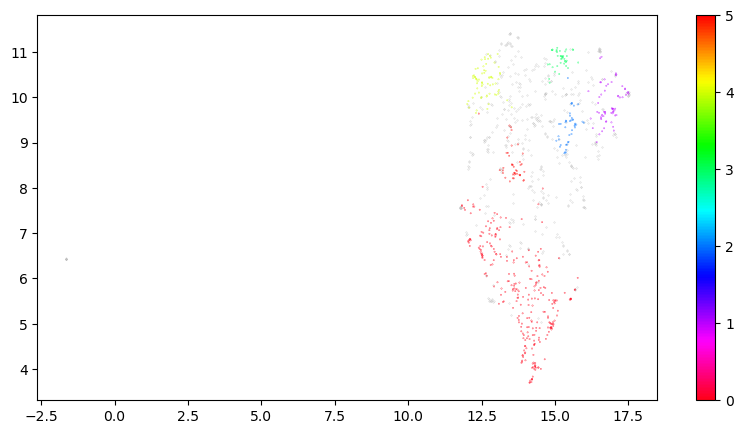

In [90]:
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Clustered TF-IDF

In [129]:
docs_df = pd.DataFrame(text, columns = ['text'])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'text': ' '.join})

In [130]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(data))

In [131]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/Users/janinedevera/opt/miniconda3/envs/tad-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,427
2,1,238
4,3,101
3,2,61
6,5,48
7,6,45
5,4,40
8,7,21
1,0,19


In [141]:
top_n_words[1][:10]

[('activision', 0.006905657198766965),
 ('deal', 0.006687424129165262),
 ('acquisition', 0.006252071693264714),
 ('cloud', 0.005573176124872544),
 ('billion', 0.005512475628019427),
 ('game', 0.005421730655356037),
 ('sony', 0.005367325511335517),
 ('announced', 0.005360809389522881),
 ('blizzard', 0.0049641807917932814),
 ('gaming', 0.004566935387692416)]

In [143]:
top_n_words[3][:10]

[('ftc', 0.011437544970115957),
 ('india', 0.00926705088817797),
 ('future', 0.008121835373573348),
 ('whatsapp', 0.00698339887267274),
 ('retail', 0.006975661037723728),
 ('arbitration', 0.006559208660652846),
 ('judge', 0.006319017010858317),
 ('giphy', 0.006262419138645957),
 ('sellers', 0.006108051485879766),
 ('instagram', 0.006012050508269187)]

In [144]:
top_n_words[2][:10]

[('fine', 0.01569219398302305),
 ('russian', 0.01384387122347253),
 ('russia', 0.013556155332437116),
 ('fined', 0.013427234277430276),
 ('million', 0.012642551584673468),
 ('roubles', 0.01257520786215803),
 ('moscow', 0.011553007770666547),
 ('fines', 0.0113440511570926),
 ('cnil', 0.009983435399267129),
 ('cookies', 0.009569651411018636)]